 # MTH8408 : Méthodes d'optimisation et contrôle optimal
 ## Laboratoire 2: Optimisation sans contraintes
Tangi Migot et Paul Raynaud

In [58]:
using Pkg
Pkg.activate(".") #Accède au fichier Project.toml
Pkg.instantiate()
Pkg.status()

  Activating project at `~/Desktop/MTH8408/Git/MTH8408-Hiv24/lab2`


Status `~/Desktop/MTH8408/Git/MTH8408-Hiv24/lab2/Project.toml`
  [54578032] ADNLPModels v0.7.0
  [7073ff75] IJulia v1.24.2
  [40e66cde] LDLFactorizations v0.10.1
  [a4795742] NLPModels v0.20.0
  [5049e819] OptimizationProblems v0.7.3
⌅ [91a5bcdd] Plots v1.39.0
  [37e2e46d] LinearAlgebra
  [de0858da] Printf
  [8dfed614] Test
Info Packages marked with ⌅ have new versions available but compatibility constraints restrict them from upgrading. To see why use `status --outdated`


In [59]:
using ADNLPModels, LinearAlgebra, NLPModels, Printf, LDLFactorizations, LinearAlgebra

In [60]:
# Problème test:
f(x) = x[1]^2 * (2*x[1] - 3) - 6*x[1]*x[2] * (x[1] - x[2] - 1) # fonction objectif vue en classe
g(x) = 6 * [x[1]^2 - x[1] - 2*x[1]*x[2] + x[2]^2 + x[2]; -x[1]^2 + 2*x[1]*x[2] + x[1]] # le gradient de f
H(x) = 6 * [2*x[1]-1-2*x[2] -2*x[1]+2*x[2]+1; -2*x[1]+2*x[2]+1 2*x[1]] # la Hessienne de f

H (generic function with 1 method)

In [61]:
#Amélioration possibles: return also the value of f
function armijo(xk, dk, fk, gk, f)
  slope = dot(gk, dk) #doit être <0
  t = 1.0
  while f(xk + t * dk) > fk + 1.0e-4 * t * slope
    t /= 1.5
  end
  return t
end

armijo (generic function with 1 method)

In [62]:
function newton_armijo(nlp, x0; verbose::Bool = true)
  t0 = time()
  xk  = x0
  fk  = obj(nlp, xk)
  gk = grad(nlp, xk)
  gnorm = gnorm0 = norm(gk)
  k = 0
  x = [xk]
  verbose && @printf "%2s %9s %9s\n" "k" "fk" "||∇f(x)||"
  verbose && @printf "%2d %9.2e %9.1e\n" k fk gnorm
  while gnorm > 1.0e-6 + 1.0e-6 * gnorm0 && k < 100 && fk > -1e15
    Hk = hess(nlp, xk)
    if neval_obj(nlp) > 1000
      println("Budget d'évaluations atteint")
      break
    end
    dk = - Hk \ gk
    slope = dot(dk, gk)
    λ = 0.0
    nb_maj = 0
    while slope ≥ -1.0e-4 * norm(dk) * gnorm
      if nb_maj <= 5
        λ = max(1.0e-3, 10 * λ)
        dk = - ((Hk + λ * I ) \ gk)
        slope = dot(dk, gk)
      else
        dk = - gk
        break
      end
      nb_maj +=1
    end
    α = armijo(xk, dk, fk, gk, f)
    xk += α * dk
    fk = f(xk)
    gk = g(xk)
    gnorm = norm(gk)
    k += 1
    push!(x, xk)
    verbose && @printf "%2d %9.2e %9.1e %7.1e \n" k fk gnorm α
    t1 = time()
    if t1 - t0 > 60
      println("Temps maximal d'éxécution atteint")
      break
    end
  end
  if fk <= -1e15
    println("Le problème est non-borné")
  end
  if k == 100
    println("Nombre maximal d'itérations atteint")
  end
  return x
end

newton_armijo (generic function with 2 methods)

In [63]:
function newton_ldlt_armijo(nlp, x0; verbose::Bool = true)
  xk  = x0
  fk  = obj(nlp, xk)
  gk = grad(nlp, xk)
  gnorm = gnorm0 = norm(gk)
  k = 0
  x = [xk]
  verbose && @printf "%2s %9s %9s\n" "k" "fk" "||∇f(x)||"
  verbose && @printf "%2d %9.2e %9.1e\n" k fk gnorm
  while gnorm > 1.0e-6 + 1.0e-6 * gnorm0 && k < 100 && fk > -1e15
    Hk = Symmetric(triu(hess(nlp, xk)), :U)
    Sk = ldl_analyze(Hk)
    ldl_factorize!(Hk, Sk)
    dk = - Sk \ gk
    α = armijo(xk, dk, fk, gk, x -> obj(nlp, x))
    xk += α * dk
    fk = obj(nlp, xk)
    gk = grad(nlp, xk)
    gnorm = norm(gk)
    k += 1
    push!(x, xk)
    verbose && @printf "%2d %9.2e %9.1e %7.1e \n" k fk gnorm α
  end
  return x
end

newton_ldlt_armijo (generic function with 1 method)

In [64]:
function bfgs_quasi_newton_armijo(nlp, x0; verbose::Bool = true)
  t0 = time()
  xk  = x0
  fk  = obj(nlp, xk)
  gk = grad(nlp, xk)
  Hk = I(length(xk))
  gnorm = gnorm0 = norm(gk)
  k = 0
  x = [xk]
  verbose && @printf "%2s %9s %9s\n" "k" "fk" "||∇f(x)||"
  verbose && @printf "%2d %9.2e %9.1e\n" k fk gnorm
  while gnorm > 1.0e-6 + 1.0e-6 * gnorm0 && k < 100 && fk > -1e15
    dk = -Hk * gk
    α = armijo(xk, dk, fk, gk, f)  
    sk = α*dk
    xk += sk
    new_fk = obj(nlp, xk)
    new_gk = grad(nlp, xk)
    yk = new_gk - gk
    if yk' * sk > 0
      ρk = 1 / dot(yk, sk)
      Hk = (I - ρk * sk * yk') * Hk * (I - ρk * yk * sk') + ρk * sk * sk'
    end
    fk, gk = new_fk, new_gk
    gnorm = norm(gk)
    k += 1
    push!(x, xk)
    verbose && @printf "%2d %9.2e %9.1e %7.1e \n" k fk gnorm α
    t1 = time()
    if t1 - t0 > 60
      println("Temps maximal d'éxécution atteint")
      break
    end
  end
  if fk <= -1e15
    println("Le problème est non-borné")
  end
  if k == 100
    println("Nombre maximal d'itérations atteint")
  end
  return x
end

bfgs_quasi_newton_armijo (generic function with 2 methods)

### Exercice 1: Méthode quasi-Newton BFGS quadratique convexe

##### Question 1

In [65]:
n = 10
A = diagm(-1 => ones(n-1), 0 => 4*ones(n), 1 => ones(n-1))
b = A * [1:n;]

f(x) = 0.5 * dot(x, A * x) - dot(b, x)
g(x) = A * x - b

g (generic function with 1 method)

In [66]:
function bfgs_quad(f, g, x0; verbose::Bool = true)
    t0 = time()
    xk = x0
    fk = f(xk)
    gk = g(xk)
    Hk = I(length(xk))
    gnorm = gnorm0 = norm(gk)
    k = 0
    verbose && @printf "%2s %9s %9s\n" "k" "fk" "||∇f(x)||"
    verbose && @printf "%2d %9.2e %9.1e\n" k fk gnorm
    while gnorm > 1.0e-6 + 1.0e-6 * gnorm0 && k < 100 && fk > -1e15
      dk = -Hk * gk
      α = -dot(gk, dk) / dot(dk, A * dk)  
      sk = α*dk
      xk += sk
      new_fk = f(xk)
      new_gk = g(xk)
      yk = new_gk - gk
      if yk' * sk > 0
        ρk = 1 / dot(yk, sk)
        Hk = (I - ρk * sk * yk') * Hk * (I - ρk * yk * sk') + ρk * sk * sk'
      end
      fk, gk = new_fk, new_gk
      gnorm = norm(gk)
      k += 1
      verbose && @printf "%2d %9.2e %9.1e %7.1e \n" k fk gnorm α
      t1 = time()
      if t1 - t0 > 60
        println("Temps maximal d'éxécution atteint")
        break
      end
    end
    if fk <= -1e15
      println("Le problème est non-borné")
    end
    if k == 100
      println("Nombre maximal d'itérations atteint")
    end
    return xk
  end

bfgs_quad (generic function with 1 method)

##### Question 2:

In [67]:
x0 = zeros(n)
bfgs_quad(f, g, x0)

 k        fk ||∇f(x)||
 0  0.00e+00   1.1e+02
 1 -1.09e+03   6.6e+00 1.7e-01 
 2 -1.10e+03   1.4e+00 2.3e-01 
 3 -1.10e+03   3.5e-01 2.6e-01 
 4 -1.10e+03   9.2e-02 2.7e-01 
 5 -1.10e+03   2.4e-02 2.7e-01 
 6 -1.10e+03   6.2e-03 2.7e-01 
 7 -1.10e+03   1.6e-03 2.8e-01 
 8 -1.10e+03   3.7e-04 2.8e-01 
 9 -1.10e+03   7.1e-05 3.0e-01 


10-element Vector{Float64}:
 1.0000185681665295
 1.9999832529289039
 3.0000076415939403
 3.99999710726788
 5.000001001568275
 5.999999670951524
 7.000000104421869
 7.9999999676835385
 9.000000009757585
 9.999999997309164

##### Question 3

$A$ est définie positive, donc par définition, $\forall d \quad d^TAd>0$

### Exercice 2: Etude de convergence

In [68]:
using Plots

f(x) = (x[2]+x[1].^2-11).^2+(x[1]+x[2].^2-7).^2
nlp = ADNLPModel(f, x0)

ADNLPModel - Model with automatic differentiation backend ADModelBackend{
  ForwardDiffADGradient,
  ForwardDiffADHvprod,
  EmptyADbackend,
  EmptyADbackend,
  EmptyADbackend,
  ForwardDiffADHessian,
  EmptyADbackend,
}
  Problem name: Generic
   All variables: ████████████████████ 10     All constraints: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
            free: ████████████████████ 10                free: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           lower: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                lower: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           upper: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                upper: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
         low/upp: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0              low/upp: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           fixed: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                fixed: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
          infeas: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0               infeas: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
            nnzh: (  0.00% sparsity)   55              linear: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
                            

In [80]:
x_armijo = newton_armijo(nlp,x0)

 k        fk ||∇f(x)||
 0  1.70e+02   2.6e+01


SingularException: SingularException(0)

In [81]:
x_ldlt = newton_ldlt_armijo(nlp,x0)

 k        fk ||∇f(x)||
 0  1.70e+02   2.6e+01


LDLFactorizations.SQDException: LDLFactorizations.SQDException("LDL' factorization was not computed or failed")

In [76]:
x_bfgs = bfgs_quasi_newton_armijo(nlp,x0)

 k        fk ||∇f(x)||
 0  1.70e+02   2.6e+01
 1  3.26e+01   4.0e+01 1.3e-01 
 2  2.81e+01   6.1e+01 1.7e-02 
 3  1.31e+01   5.2e+01 4.4e-01 
 4  3.80e+00   2.3e+01 1.0e+00 
 5  1.78e-01   5.0e+00 1.0e+00 
 6  8.59e-03   9.5e-01 1.0e+00 
 7  1.47e-03   2.9e-01 1.0e+00 
 8  6.18e-05   6.7e-02 1.0e+00 
 9  5.60e-07   9.1e-03 1.0e+00 
10  1.94e-09   5.4e-04 1.0e+00 
11  1.98e-12   1.2e-05 1.0e+00 


12-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [1.8436213991769546, 2.8971193415637857, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [2.570158770734812, 3.0930774207795926, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [3.451994938111786, 2.2879435828967436, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [2.688710947550812, 1.9220592807442438, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [2.925647268511114, 2.0185154215535857, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [3.0017414961503786, 2.02122901710842, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [2.99694724265308, 2.010091351321117, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [2.998749017898697, 2.0016151358430396, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [2.9998702915112117, 2.0000298211784777, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [2.9999959244281196, 1.999993236606497, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [3.0000000543990195, 1.9999996348436917, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

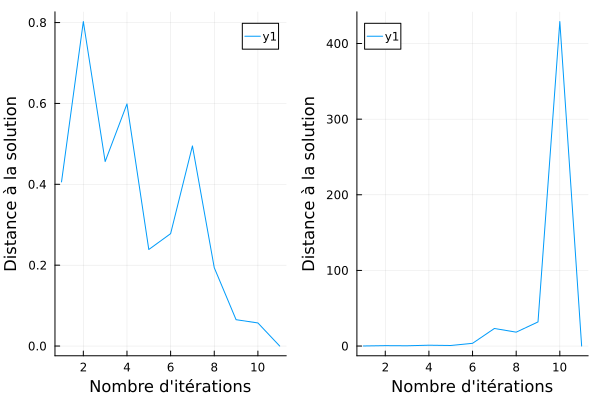

In [79]:
dbfgs_lin=[]
dbfgs_quad=[]
for k=1:length(x_bfqs)-1
    norm_lin = (norm(x_bfgs[k+1]-x_bfgs[end]))/(norm(x_bfgs[k]-x_bfgs[end]))
    norm_quad = (norm(x_bfgs[k+1]-x_bfgs[end]))/(norm(x_bfgs[k]-x_bfgs[end]))^2
    push!(dbfgs_lin, norm_lin)
    push!(dbfgs_quad, norm_quad)
end

plot5 = plot(1:length(dbfgs_lin), dbfgs_lin, xlabel="Nombre d'itérations", ylabel="Distance à la solution")
plot6 = plot(1:length(dbfgs_quad), dbfgs_quad, xlabel="Nombre d'itérations", ylabel="Distance à la solution")
plot(plot5, plot6)